# Evolución de imágenes (EA) — Objetivo: replicar una imagen objetivo

Este notebook muestra paso a paso un **algoritmo evolutivo** que intenta reconstruir una imagen objetivo partiendo de una población aleatoria de 50 imágenes RGB (tamaño 120×180, valores 0–255).

**Configuración**:

- Población: 50 individuos.
- Tamaño imagen: 120×180 píxeles, 3 canales (RGB).
- Aptitud (fitness): similaridad a la imagen objetivo medida por MSE (mean squared error). Se busca minimizar el MSE.
- Operadores: torneo (selección), crossover uniforme por píxel, mutación aditiva en píxeles aleatorios.

El notebook contiene código ejecutable dividido en bloques: definición de funciones, inicialización, evaluación, bucle evolutivo, visualizaciones y parámetros para experimentar.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

IMG_H, IMG_W = 120, 180
POP_SIZE = 50

# Funciones auxiliares
def make_random_image(h=IMG_H, w=IMG_W, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0,256, size=(h,w,3), dtype=np.uint8)

def show_image(ax, img, title=None):
    ax.imshow(img.astype(np.uint8))
    ax.axis('off')
    if title is not None:
        ax.set_title(title, fontsize=10)

def initialize_population(pop_size=POP_SIZE, h=IMG_H, w=IMG_W, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0,256, size=(pop_size,h,w,3), dtype=np.uint8)

def mse_batch(pop, target):
    diff = pop.astype(np.int32) - target.astype(np.int32)
    mse = np.mean(diff*diff, axis=(1,2,3))
    return mse


## Operadores evolutivos
Definición de selección por torneo, crossover uniforme y mutación aditiva por píxel.

In [2]:
# Operadores y bucle evolutivo
def tournament_select(pop, mse, k=3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    idxs = rng.integers(0, N, size=(N, k))
    selected = []
    for row in idxs:
        best = row[np.argmin(mse[row])]
        selected.append(best)
    return np.array(selected, dtype=int)

def uniform_crossover(parent_a, parent_b, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mask = rng.random(parent_a.shape) < 0.5
    child = np.where(mask, parent_a, parent_b).astype(np.uint8)
    return child

def mutate_image(img, mutation_prob_pixel=1e-3, mutation_std=15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    img = img.astype(np.int32)
    mask = rng.random(img.shape) < mutation_prob_pixel
    if not mask.any():
        return img.astype(np.uint8)
    noise = rng.normal(loc=0.0, scale=mutation_std, size=img.shape).astype(np.int32)
    img[mask] += noise[mask]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def evolve(pop, target, max_gens=500, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    history = []
    mse = mse_batch(pop, target)
    best_idx = int(np.argmin(mse))
    history.append(mse[best_idx])
    for gen in range(1, max_gens+1):
        sel_idxs = tournament_select(pop, mse, k=3, rng=rng)
        parents = pop[sel_idxs]
        offspring = np.empty_like(parents)
        for i in range(0, N, 2):
            a = parents[i]
            b = parents[i+1 if i+1<N else 0]
            if rng.random() < 0.9:
                child1 = uniform_crossover(a, b, rng=rng)
                child2 = uniform_crossover(b, a, rng=rng)
            else:
                child1 = a.copy(); child2 = b.copy()
            child1 = mutate_image(child1, mutation_prob_pixel=1e-3, mutation_std=15, rng=rng)
            child2 = mutate_image(child2, mutation_prob_pixel=1e-3, mutation_std=15, rng=rng)
            offspring[i] = child1
            if i+1 < N:
                offspring[i+1] = child2
        pop = offspring
        mse = mse_batch(pop, target)
        best_idx = int(np.argmin(mse))
        history.append(mse[best_idx])
        if gen % 10 == 0:
            print(f'Gen {gen}: best MSE = {history[-1]:.2f}')
        if mse[best_idx] == 0:
            print('Perfect match found at generation', gen)
            break
    best_idx = int(np.argmin(mse))
    return pop, np.array(history), pop[best_idx], mse[best_idx]


## Ejecución de ejemplo
Cree un target aleatorio, inicialice la población y ejecute el bucle evolutivo. Se muestran la comparación entre target y el mejor individuo, y la curva de convergencia.

Población y target creados. Ejecutando evolución...
Gen 10: best MSE = 10601.46
Gen 20: best MSE = 10445.61
Gen 30: best MSE = 10317.22
Gen 40: best MSE = 10236.51
Gen 50: best MSE = 10184.83
Gen 60: best MSE = 10156.13
Gen 70: best MSE = 10134.49
Gen 80: best MSE = 10119.39
Gen 90: best MSE = 10108.14
Gen 100: best MSE = 10096.84
Gen 110: best MSE = 10089.38
Gen 120: best MSE = 10081.18
Gen 130: best MSE = 10072.33
Gen 140: best MSE = 10064.75
Gen 150: best MSE = 10056.57
Gen 160: best MSE = 10048.04
Gen 170: best MSE = 10042.38
Gen 180: best MSE = 10033.84
Gen 190: best MSE = 10026.06
Gen 200: best MSE = 10019.50
Gen 210: best MSE = 10010.60
Gen 220: best MSE = 10002.90
Gen 230: best MSE = 9994.13
Gen 240: best MSE = 9987.02
Gen 250: best MSE = 9978.92
Gen 260: best MSE = 9970.11
Gen 270: best MSE = 9962.64
Gen 280: best MSE = 9956.02
Gen 290: best MSE = 9947.08
Gen 300: best MSE = 9940.36


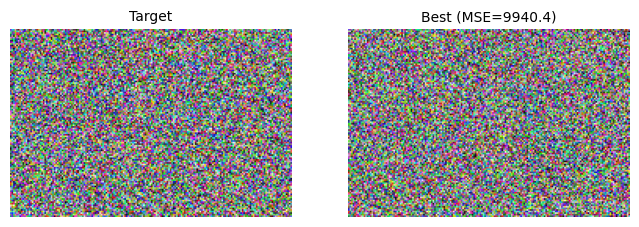

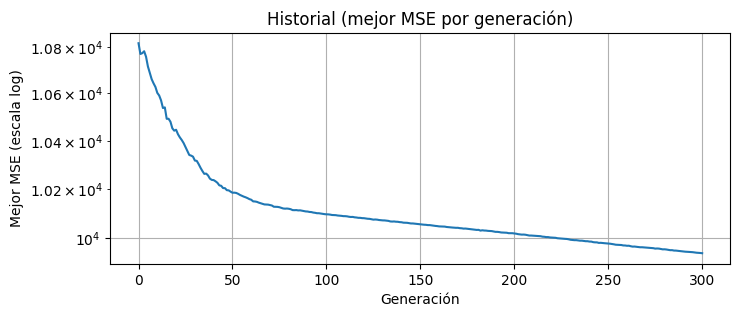

In [3]:
# Uso: crear target, inicializar población y ejecutar
rng = np.random.default_rng(42)
target = make_random_image(rng=rng)
pop = initialize_population(rng=rng)

print('Población y target creados. Ejecutando evolución...')
pop, history, best_img, best_mse = evolve(pop, target, max_gens=300, rng=rng)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(8,4))
show_image(ax[0], target, title='Target')
show_image(ax[1], best_img, title=f'Best (MSE={best_mse:.1f})')
plt.show()

plt.figure(figsize=(8,3))
plt.plot(history)
plt.yscale('log')
plt.title('Historial (mejor MSE por generación)')
plt.xlabel('Generación')
plt.ylabel('Mejor MSE (escala log)')
plt.grid(True)
plt.show()
